## Text Analytics Assignment 4
### POS Tagger with BiGRU
***

#### Mounting GDrive to Colab


In [ ]:
### Imports
import pickle
import numpy as np
import pandas as pd
from nltk.util import ngrams
from collections import OrderedDict as OD, Counter
from math import floor
from sklearn.metrics import *
!pip install keras-tuner
import kerastuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from scipy import interp
from scipy.special import softmax
from sklearn.dummy import DummyClassifier
from random import choices
from tqdm import tqdm
from keras.utils.np_utils import to_categorical

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=6dd08490fcf3b0a7b8c1ca8927ed590d30596c175033b83f506f839f87c536b0
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=115a0c403458d4bb77bc59fc50e17c0b6f3416ecd5eaa19bf722e177a6e274d6
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


Using TensorFlow backend.


In [ ]:
### We need to install conllu to read the pos-tagged files of the UL Dataset
!pip install conllu
import conllu
from conllu import parse,parse_incr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Download, unzip & load Fasttext word embeddings (no need to re-run)
***

In [ ]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# !gzip -d cc.en.300.vec.gz

### Load fasttext embeddings (no need to re-run)

In [ ]:
# idx = 0
# vocab = {}
# with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n', errors='ignore') as f:
#     for l in f:
#         line = l.rstrip().split(' ')
#         if idx == 0:
#             vocab_size = int(line[0]) + 2 # Find Vocabulary size from header description at line 1
#             dim = int(line[1]) # Find embeddings dimensionality from header description at line 1 
#             vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
#             vocab["__PADDING__"] = 0 # Pad symbol index 0
#             vocab["__UNK__"] = 1 # Unk symbol index 1
#             idx = 2 # Skip one line
#         else:
#             vocab[line[0]] = idx
#             emb = np.array(line[1:]).astype(np.float)
#             if (emb.shape[0] == dim):
#                 vecs[idx,:] = emb
#                 idx+=1
#             else:
#                 continue

#     pickle.dump(vocab,open("/content/gdrive/My Drive/Fasttext/fasttext_voc.pkl" ,'wb')) # Save vocab Mapping
#     np.save("/content/gdrive/My Drive/Fasttext/fasttext.npy",vecs) # Save Numpy Matrix
#     # Release Memory
#     vecs = None
#     vocab = None
#     emb = None

### Load embeddings np-array and mapping dictionary.
***

In [ ]:
fasttext_embed = np.load('/content/gdrive/My Drive/Fasttext/fasttext.npy')
fasttext_word_to_index = pickle.load(open('/content/gdrive/My Drive/Fasttext/fasttext_voc.pkl', 'rb'))

### Create Helper Functions and Load the Conllu Files from GDrive
***

In [ ]:
def preprocessing(word):
  """
    Since we do not want to change vastly the dataset due to the POS Tagging Task,
    we procees with minimal preprocessing of replacing emails with symbol @
    and numbers with number 0.
  """
  word = str(word).lower()
  if word.isnumeric():
    return '0'

  if '@' in word:
    return '@'
  
  return word

In [ ]:
def list_flat(alist):
  """
    Flattens a list of lists into a single list.
  """
  flat_list = []
  for sublist in alist:
      for item in sublist:
          flat_list.append(item)
  return flat_list

In [ ]:
def convert_to_dataset(conllu_file):
  """
    Converts a Conllu File into Sentences and POS Tags.
  """
  data_file = open(conllu_file, "r", encoding="utf-8")
  sentences = []
  pos_tags = []
  length = []
  for tokenlist in parse_incr(data_file):
      sentence = [preprocessing(f['lemma']) for f in tokenlist]
      if len(sentence) > 2:
        tags = [f['upos'] for f in tokenlist]
        length.append(len(sentence))
        sentences.append(sentence)
        pos_tags.append(tags)

  min_length = floor(np.array(length).min())
  avg_length = floor(np.array(length).mean())
  std_length = floor(np.array(length).std())
  max_length = floor(np.array(length).max())
  print(f"Found {len(sentences)} sentences of min size {min_length} average size from: {max(3,avg_length-2*std_length)} to: {max(3,avg_length+2*std_length)} and max size {max_length} in the dataset!\n")

  return sentences, pos_tags

def create_dummy_classifier_dataset(data):
  """
    Creates Window Size 1 dataset for the Dummy Classifier.
  """
  z_sentences = list_flat(data[0])
  z_pos_tags = list_flat(data[1])
  return z_sentences, z_pos_tags

def convert_to_window_dataset(x_data, y_data, window_size):
  """
    Converts Dataset from sentences to windows of words of size (window_size).
    Pads the Sentences in order to keep same window length across the creation
    of the sets.
  """
  z_sentences = x_data
  z_pos_tags = list_flat(y_data)
  windowed_sentences = []


  for sentence in z_sentences:
      gen = ngrams(sentence, window_size, pad_left=True, pad_right=True, left_pad_symbol=0, right_pad_symbol=0)
      if window_size != 1:
        for f in list(gen)[window_size//2:-(window_size//2)]:
            windowed_sentences.append(list(f))
      else:
         for f in list(gen):
           windowed_sentences.append(f)
  return windowed_sentences, z_pos_tags

def post_padding_for_RNN(x_data, y_data, max_length=100, pad_id=0, pad_token=17):
  """
    Pads the Sentences and the Labels in order to keep same window length across the creation
    of the sets.
  """
  z_sentences = x_data
  z_pos_tags = y_data
  
  padded_sentences = []
  padded_tags = []

  for s,t in zip(z_sentences, z_pos_tags):
    if len(s) <= max_length:
      padded_sentences.append(s + (max_length - len(s))*[pad_id])
      padded_tags.append(t + (max_length - len(t))*[pad_token])
  return padded_sentences, padded_tags

In [ ]:
### Load the Datasets
train_data, train_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/train.conllu')
dev_data, dev_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/dev.conllu')
test_data, test_pos_tags = convert_to_dataset('/content/gdrive/My Drive/Fasttext/Dataset/test.conllu')

Found 4094 sentences of min size 3 average size from: 3 to: 43 and max size 99 in the dataset!

Found 751 sentences of min size 3 average size from: 3 to: 46 and max size 88 in the dataset!

Found 852 sentences of min size 3 average size from: 3 to: 40 and max size 84 in the dataset!



In [ ]:
### Get all the known labels and make a set in order to enumerate them
labels = {}
unique = set(list_flat(train_pos_tags))
for k,v in enumerate(sorted(unique)):
  labels.update({v:k})

In [ ]:
### Theese are the target Categories!
labels

{'ADJ': 0,
 'ADP': 1,
 'ADV': 2,
 'AUX': 3,
 'CCONJ': 4,
 'DET': 5,
 'INTJ': 6,
 'NOUN': 7,
 'NUM': 8,
 'PART': 9,
 'PRON': 10,
 'PROPN': 11,
 'PUNCT': 12,
 'SCONJ': 13,
 'SYM': 14,
 'VERB': 15,
 'X': 16}

In [ ]:
### Get all known words in train set and make a vocabulary out of them
### Add the Special Tokens
train_vocab = set(list_flat(train_data))
train_vocab = {v:k+2 for k,v in enumerate(sorted(train_vocab))}

train_vocab.update({'__PADDING__': 0})
train_vocab.update({'__UNK__': 1})

### Initialize embedding matrix with fasttext pre-trained embedings
***

In [ ]:
MAX_WORDS = len(train_vocab) # instead of 2000000 + 2
# We dont need the full matrix just the number of words in our dataset.
# We try to limit this for RAM reasons.
print(f"Total Number of Words: {MAX_WORDS}\n")
EMBEDDING_DIM = fasttext_embed.shape[1]
print(f"Embedding Dimension: {EMBEDDING_DIM}\n")

Total Number of Words: 8746

Embedding Dimension: 300



In [ ]:
embedding_matrix = np.random.uniform(low=-1,high=1, size=(MAX_WORDS, EMBEDDING_DIM))
for word, i in train_vocab.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

### Clean Memory
del fasttext_embed
del fasttext_word_to_index

### Prepare Datasets for Training / Tuning
***

In [ ]:
### Tokenize Train/Dev/Test Sets

x_train_tokenized = []
for sentence in train_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_train_tokenized.append(tokenized_sentence)

### Clean Memory
del train_data

x_dev_tokenized = []
for sentence in dev_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_dev_tokenized.append(tokenized_sentence)

### Clean Memory
del dev_data



x_test_tokenized = []
for sentence in test_data:
    tokenized_sentence = []
    for token in sentence:
        if token in train_vocab:
            tokenized_sentence.append(train_vocab[token])
        else:
            tokenized_sentence.append(train_vocab['__UNK__'])
    x_test_tokenized.append(tokenized_sentence)

### Clean Memory
del test_data

In [ ]:
### Convert Train/Dev/Test targets
y_train_tokenized = []
for sentence in train_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_train_tokenized.append(tokenized_labels)

### Clean Memory
del train_pos_tags

y_dev_tokenized = []
for sentence in dev_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_dev_tokenized.append(tokenized_labels)

### Clean Memory
del dev_pos_tags


y_test_tokenized = []
for sentence in test_pos_tags:
    tokenized_labels = []
    for label in sentence:
      tokenized_labels.append(labels[label])
    y_test_tokenized.append(tokenized_labels)

### Clean Memory
del test_pos_tags

### Create BaseLine Classifier
***


In [ ]:
class CustomDummyClassifier:
    def __init__(self):
        self.occurance_dict = {}
        self.most_frequent = None
        return
    
    
    def _most_freq(self, x_array, y_array, idx):
        # Custom "Most Frequent" Calculator
        try:
            mf = Counter(y_array[x_array == idx]).most_common(1)[0][0]
        except IndexError:
            # Nothing Found for Token
            return Counter(y_array).most_common(1)[0][0]
        return mf
    
    def fit(self,x_train,y_train,vocab_len=8746):
        self.most_frequent = Counter(y_train).most_common(1)[0][0]
        for i in range(0, vocab_len):
            mode = self._most_freq(x_train,y_train,i)
            self.occurance_dict.update({i:mode})
        return
    
    def predict(self, x_test):
        results = []
        for x in x_test:
            if x in self.occurance_dict:
                results.append(self.occurance_dict[x])
            else:
                results.append(self.most_frequent)
        
        return np.array(results)

In [ ]:
x_train, y_train = create_dummy_classifier_dataset([x_train_tokenized, y_train_tokenized])
x_test, y_test = create_dummy_classifier_dataset([x_test_tokenized, y_test_tokenized])

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train = np.array(y_train)
y_train = y_train.astype('int16')

x_test = np.array(x_test)
x_test = x_test.astype('float32')

y_test = np.array(y_test)
y_test = y_test.astype('int16')

In [ ]:
base = CustomDummyClassifier()
base.fit(x_train, y_train)
predictions = base.predict(x_train)

score = accuracy_score(y_train, predictions)
print("train accuracy: %.6f%%" % (score*100))

predictions_base_test = base.predict(x_test)
score = accuracy_score(y_test, predictions_base_test)
print("test accuracy: %.6f%%" % (score*100))

train accuracy: 91.913667%
test accuracy: 83.513990%


In [ ]:
macrof1_tst_bs = f1_score(y_test, predictions_base_test,average="macro")
macrof1_tst_bs

0.7543896914831633

### Prepare Data for RNN
***

In [ ]:
x_train, y_train = post_padding_for_RNN(x_train_tokenized, y_train_tokenized)
x_dev, y_dev = post_padding_for_RNN(x_dev_tokenized, y_dev_tokenized)
x_test, y_test = post_padding_for_RNN(x_test_tokenized, y_test_tokenized)

In [ ]:
x_train = np.array(x_train)
x_train = x_train.astype('float32')

x_dev = np.array(x_dev)
x_dev = x_dev.astype('float32')

y_train = np.array(y_train)
y_train = np.expand_dims(y_train,-1)
y_train = y_train.astype('int16')

y_dev = np.array(y_dev)
y_dev = np.expand_dims(y_dev,-1)
y_dev = y_dev.astype('int16')

x_test = np.array(x_test)
x_test = x_test.astype('float32')

y_test = np.array(y_test)
y_test = y_test.astype('int16')

### Create the BiGRU POS TAGGER
***

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
### Custom Callbacks
class MultiOutputF1Score(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, mode='val', pad_id=17):
        super(MultiOutputF1Score, self).__init__()
        self.validation_data = valid_data
        self.mode = mode
        self.pad_id = pad_id

    def on_epoch_end(self, epoch, logs=None):
        mode = self.mode
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1).reshape(-1)
        val_targ = self.validation_data[1].reshape(-1)

        #### Dont calculate Loss on Padded Timesteps
        cidx = np.where(val_targ != self.pad_id)[0]

        val_targ = val_targ[cidx]
        val_predict = val_predict[cidx]


        val_targ = K.cast(val_targ, dtype=tf.float32)
        val_predict = K.cast(val_predict, dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs[f'{mode}_f1'] = _val_f1
        logs[f'{mode}_recall'] = _val_recall
        logs[f'{mode}_precision'] = _val_precision
        return

In [ ]:
es = EarlyStopping(monitor='val_f1', verbose=2, patience=6, mode='max', restore_best_weights=True)
rdlr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=3, verbose=0, mode='max')

my_callbacks = [es, rdlr]

### Model Tuning
***

In [ ]:
### Destroy old Oracle
!rm -rf tuning


### Tunable Model
def model_builder(hp):
  model = Sequential()
  model.add(Embedding(input_shape=(100,),input_dim=len(train_vocab), output_dim=300, weights=[embedding_matrix], input_length=100, mask_zero=True, trainable=False))
  model.add(Dropout(rate=0.2))
  for i in range(hp.Int('num_gru_layers', 1, 2)):
    model.add(Bidirectional(GRU(units=hp.Int('gru_units_' +str(i), min_value=256, max_value=512, step=128),dropout=hp.Choice('gru_dropout_'+str(i), [0.0,0.1,0.2]), reset_after=True, return_sequences=True)))

  for i in range(hp.Int('num_layers', 1, 2)):
    model.add(TimeDistributed(Dense(units=hp.Int('units_' + str(i), min_value=64, max_value=256, step=64), activation='relu')))
    model.add(TimeDistributed(Dropout(rate=0.2)))
  model.add(TimeDistributed(Dense(units=len(labels)+1, activation='softmax')))
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='sparse_categorical_crossentropy')
  return model



### Create Custom Bayesian Tuner
class MyTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = 128
    kwargs['epochs'] = 10
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Overload arguments with our custom metric.
tuner = MyTuner(
    model_builder,
    objective=kerastuner.Objective('val_f1', direction='max'),
    max_trials=30,
    directory='.',
    project_name='tuning')

### Search Space 
tuner.search(x_train, y_train,
             epochs=5, callbacks=[MultiOutputF1Score(mode='val',valid_data=(x_dev, y_dev))] + my_callbacks,
             validation_data=(x_dev, y_dev))

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3796

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 306ms/step - loss: 0.3796 - val_loss: 0.1971 - val_f1: 0.6766 - val_recall: 0.7119 - val_precision: 0.6949 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 80ms/step - loss: 0.1577 - val_loss: 0.1028 - val_f1: 0.8320 - val_recall: 0.8427 - val_precision: 0.8431 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 79ms/step - loss: 0.1002 - val_loss: 0.0783 - val_f1: 0.8704 - val_recall: 0.8762 - val_precision: 0.8774 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 79ms/step - loss: 0.0799 - val_loss: 0.0716 - val_f1: 0.8768 - val_recall: 0.8845 - val_precision: 0.8882 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 80ms/step - loss: 0.0716 - val_loss: 0.0649 - val_f1: 0.8905 - val_recall: 0.8950 - val_precision: 0.8944 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 75ms/step - loss: 0.0642 - val_loss: 0.0684 - val_f1: 0.8835 - val_recall: 0.8919 - 

Epoch 1/10
32/32 [==============================] - 5s 154ms/step - loss: 0.3518 - val_loss: 0.2077 - val_f1: 0.6852 - val_recall: 0.7090 - val_precision: 0.7099 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 1s 38ms/step - loss: 0.1592 - val_loss: 0.1176 - val_f1: 0.8157 - val_recall: 0.8237 - val_precision: 0.8204 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.1062 - val_loss: 0.0917 - val_f1: 0.8535 - val_recall: 0.8601 - val_precision: 0.8611 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0872 - val_loss: 0.0805 - val_f1: 0.8702 - val_recall: 0.8759 - val_precision: 0.8762 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0774 - val_loss: 0.0757 - val_f1: 0.8725 - val_recall: 0.8794 - val_precision: 0.8816 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 54ms/step - loss: 0.0703 - val_loss: 0.0719 - val_f1: 0.8795 - val_recall:

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3518

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 337ms/step - loss: 0.3518 - val_loss: 0.1746 - val_f1: 0.7135 - val_recall: 0.7382 - val_precision: 0.7295 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 113ms/step - loss: 0.1414 - val_loss: 0.0950 - val_f1: 0.8369 - val_recall: 0.8471 - val_precision: 0.8459 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 111ms/step - loss: 0.0926 - val_loss: 0.0802 - val_f1: 0.8680 - val_recall: 0.8758 - val_precision: 0.8787 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 112ms/step - loss: 0.0762 - val_loss: 0.0692 - val_f1: 0.8807 - val_recall: 0.8863 - val_precision: 0.8858 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 4s 113ms/step - loss: 0.0672 - val_loss: 0.0683 - val_f1: 0.8850 - val_recall: 0.8935 - val_precision: 0.8975 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 4s 112ms/step - loss: 0.0600 - val_loss: 0.0621 - val_f1: 0.8938 - val_recall: 0.89

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3104

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 308ms/step - loss: 0.3104 - val_loss: 0.1578 - val_f1: 0.7550 - val_recall: 0.7674 - val_precision: 0.7654 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 84ms/step - loss: 0.1222 - val_loss: 0.0885 - val_f1: 0.8522 - val_recall: 0.8580 - val_precision: 0.8540 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 82ms/step - loss: 0.0848 - val_loss: 0.0758 - val_f1: 0.8678 - val_recall: 0.8761 - val_precision: 0.8804 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0720 - val_loss: 0.0682 - val_f1: 0.8852 - val_recall: 0.8886 - val_precision: 0.8893 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 83ms/step - loss: 0.0641 - val_loss: 0.0639 - val_f1: 0.8903 - val_recall: 0.8946 - val_precision: 0.8939 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 78ms/step - loss: 0.0586 - val_loss: 0.0685 - val_f1: 0.8839 - val_recall: 0.8925 - 

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3573

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 6s 176ms/step - loss: 0.3573 - val_loss: 0.1887 - val_f1: 0.7101 - val_recall: 0.7374 - val_precision: 0.7254 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 59ms/step - loss: 0.1584 - val_loss: 0.1095 - val_f1: 0.8224 - val_recall: 0.8334 - val_precision: 0.8313 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 72ms/step - loss: 0.1094 - val_loss: 0.0879 - val_f1: 0.8524 - val_recall: 0.8614 - val_precision: 0.8624 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 58ms/step - loss: 0.0918 - val_loss: 0.0798 - val_f1: 0.8625 - val_recall: 0.8718 - val_precision: 0.8732 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 58ms/step - loss: 0.0817 - val_loss: 0.0716 - val_f1: 0.8807 - val_recall: 0.8872 - val_precision: 0.8890 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 54ms/step - loss: 0.0740 - val_loss: 0.0734 - val_f1: 0.8787 - val_recall: 0.8876 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3235

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 335ms/step - loss: 0.3235 - val_loss: 0.1577 - val_f1: 0.7296 - val_recall: 0.7546 - val_precision: 0.7508 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 105ms/step - loss: 0.1305 - val_loss: 0.0893 - val_f1: 0.8486 - val_recall: 0.8561 - val_precision: 0.8501 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 105ms/step - loss: 0.0902 - val_loss: 0.0735 - val_f1: 0.8747 - val_recall: 0.8807 - val_precision: 0.8782 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 105ms/step - loss: 0.0760 - val_loss: 0.0686 - val_f1: 0.8836 - val_recall: 0.8908 - val_precision: 0.8907 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 99ms/step - loss: 0.0671 - val_loss: 0.0727 - val_f1: 0.8813 - val_recall: 0.8906 - val_precision: 0.9008 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0623 - val_loss: 0.0700 - val_f1: 0.8835 - val_recall: 0.8924

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3716

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 324ms/step - loss: 0.3716 - val_loss: 0.1916 - val_f1: 0.6874 - val_recall: 0.7195 - val_precision: 0.6856 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 95ms/step - loss: 0.1673 - val_loss: 0.1092 - val_f1: 0.8224 - val_recall: 0.8345 - val_precision: 0.8320 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 95ms/step - loss: 0.1125 - val_loss: 0.0836 - val_f1: 0.8636 - val_recall: 0.8718 - val_precision: 0.8702 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0910 - val_loss: 0.0725 - val_f1: 0.8831 - val_recall: 0.8892 - val_precision: 0.8886 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 94ms/step - loss: 0.0775 - val_loss: 0.0677 - val_f1: 0.8873 - val_recall: 0.8926 - val_precision: 0.8934 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0693 - val_loss: 0.0655 - val_f1: 0.8892 - val_recall: 0.8947 - 

Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.3548

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 5s 160ms/step - loss: 0.3506 - val_loss: 0.2022 - val_f1: 0.6735 - val_recall: 0.7054 - val_precision: 0.7049 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 1s 40ms/step - loss: 0.1552 - val_loss: 0.1147 - val_f1: 0.8186 - val_recall: 0.8276 - val_precision: 0.8240 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 1s 40ms/step - loss: 0.1046 - val_loss: 0.0907 - val_f1: 0.8538 - val_recall: 0.8608 - val_precision: 0.8626 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 54ms/step - loss: 0.0876 - val_loss: 0.0798 - val_f1: 0.8717 - val_recall: 0.8765 - val_precision: 0.8781 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 1s 41ms/step - loss: 0.0787 - val_loss: 0.0759 - val_f1: 0.8772 - val_recall: 0.8812 - val_precision: 0.8852 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 1s 38ms/step - loss: 0.0734 - val_loss: 0.0729 - val_f1: 0.8753 - val_recall: 0.8826 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3669

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 5s 171ms/step - loss: 0.3669 - val_loss: 0.1998 - val_f1: 0.6736 - val_recall: 0.7076 - val_precision: 0.6981 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 56ms/step - loss: 0.1629 - val_loss: 0.1103 - val_f1: 0.8186 - val_recall: 0.8307 - val_precision: 0.8294 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 69ms/step - loss: 0.1103 - val_loss: 0.0892 - val_f1: 0.8521 - val_recall: 0.8616 - val_precision: 0.8637 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 56ms/step - loss: 0.0914 - val_loss: 0.0766 - val_f1: 0.8718 - val_recall: 0.8782 - val_precision: 0.8745 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 58ms/step - loss: 0.0816 - val_loss: 0.0736 - val_f1: 0.8754 - val_recall: 0.8829 - val_precision: 0.8822 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 55ms/step - loss: 0.0758 - val_loss: 0.0694 - val_f1: 0.8823 - val_recall: 0.8899 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3169

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 333ms/step - loss: 0.3169 - val_loss: 0.1572 - val_f1: 0.7516 - val_recall: 0.7677 - val_precision: 0.7579 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 102ms/step - loss: 0.1269 - val_loss: 0.0882 - val_f1: 0.8559 - val_recall: 0.8616 - val_precision: 0.8606 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0879 - val_loss: 0.0741 - val_f1: 0.8766 - val_recall: 0.8823 - val_precision: 0.8834 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0722 - val_loss: 0.0691 - val_f1: 0.8838 - val_recall: 0.8897 - val_precision: 0.8940 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0644 - val_loss: 0.0661 - val_f1: 0.8893 - val_recall: 0.8948 - val_precision: 0.9001 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0582 - val_loss: 0.0621 - val_f1: 0.8976 - val_recall: 0.90

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3301

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 339ms/step - loss: 0.3301 - val_loss: 0.1595 - val_f1: 0.7402 - val_recall: 0.7605 - val_precision: 0.7618 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 111ms/step - loss: 0.1304 - val_loss: 0.0884 - val_f1: 0.8591 - val_recall: 0.8653 - val_precision: 0.8615 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 110ms/step - loss: 0.0867 - val_loss: 0.0732 - val_f1: 0.8820 - val_recall: 0.8861 - val_precision: 0.8881 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 114ms/step - loss: 0.0720 - val_loss: 0.0682 - val_f1: 0.8871 - val_recall: 0.8936 - val_precision: 0.8961 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 103ms/step - loss: 0.0626 - val_loss: 0.0697 - val_f1: 0.8860 - val_recall: 0.8937 - val_precision: 0.8989 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 103ms/step - loss: 0.0568 - val_loss: 0.0745 - val_f1: 0.8839 - val_recall: 0.89

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.2969

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 323ms/step - loss: 0.2969 - val_loss: 0.1424 - val_f1: 0.7735 - val_recall: 0.7851 - val_precision: 0.7764 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 99ms/step - loss: 0.1116 - val_loss: 0.0839 - val_f1: 0.8652 - val_recall: 0.8693 - val_precision: 0.8665 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 97ms/step - loss: 0.0793 - val_loss: 0.0731 - val_f1: 0.8779 - val_recall: 0.8844 - val_precision: 0.8867 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0661 - val_loss: 0.0663 - val_f1: 0.8910 - val_recall: 0.8953 - val_precision: 0.8944 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0591 - val_loss: 0.0658 - val_f1: 0.8919 - val_recall: 0.8976 - val_precision: 0.9028 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 99ms/step - loss: 0.0539 - val_loss: 0.0607 - val_f1: 0.8981 - val_recall: 0.9021 - 

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3410

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 324ms/step - loss: 0.3410 - val_loss: 0.1730 - val_f1: 0.7173 - val_recall: 0.7389 - val_precision: 0.7439 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 92ms/step - loss: 0.1323 - val_loss: 0.0929 - val_f1: 0.8443 - val_recall: 0.8511 - val_precision: 0.8494 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0852 - val_loss: 0.0748 - val_f1: 0.8725 - val_recall: 0.8800 - val_precision: 0.8846 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0704 - val_loss: 0.0695 - val_f1: 0.8859 - val_recall: 0.8923 - val_precision: 0.8938 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 85ms/step - loss: 0.0621 - val_loss: 0.0695 - val_f1: 0.8850 - val_recall: 0.8931 - val_precision: 0.9006 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 90ms/step - loss: 0.0558 - val_loss: 0.0610 - val_f1: 0.8979 - val_recall: 0.9014 - 

Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.3656

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 298ms/step - loss: 0.3611 - val_loss: 0.1989 - val_f1: 0.6926 - val_recall: 0.7144 - val_precision: 0.7019 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 67ms/step - loss: 0.1531 - val_loss: 0.1040 - val_f1: 0.8327 - val_recall: 0.8412 - val_precision: 0.8377 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 68ms/step - loss: 0.0998 - val_loss: 0.0823 - val_f1: 0.8628 - val_recall: 0.8695 - val_precision: 0.8687 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 67ms/step - loss: 0.0810 - val_loss: 0.0739 - val_f1: 0.8790 - val_recall: 0.8845 - val_precision: 0.8855 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 67ms/step - loss: 0.0707 - val_loss: 0.0726 - val_f1: 0.8795 - val_recall: 0.8871 - val_precision: 0.8932 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 67ms/step - loss: 0.0643 - val_loss: 0.0672 - val_f1: 0.8865 - val_recall: 0.8933 - 

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3369

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 310ms/step - loss: 0.3369 - val_loss: 0.1638 - val_f1: 0.7318 - val_recall: 0.7539 - val_precision: 0.7503 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 86ms/step - loss: 0.1298 - val_loss: 0.0935 - val_f1: 0.8423 - val_recall: 0.8523 - val_precision: 0.8506 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0891 - val_loss: 0.0781 - val_f1: 0.8682 - val_recall: 0.8764 - val_precision: 0.8804 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0740 - val_loss: 0.0719 - val_f1: 0.8768 - val_recall: 0.8851 - val_precision: 0.8889 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0666 - val_loss: 0.0722 - val_f1: 0.8815 - val_recall: 0.8909 - val_precision: 0.8979 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0614 - val_loss: 0.0658 - val_f1: 0.8874 - val_recall: 0.8946 - 

Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.4272

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 5s 155ms/step - loss: 0.4221 - val_loss: 0.2646 - val_f1: 0.5557 - val_recall: 0.6155 - val_precision: 0.5927 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 0.2169 - val_loss: 0.1458 - val_f1: 0.7602 - val_recall: 0.7840 - val_precision: 0.7765 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 0.1455 - val_loss: 0.1076 - val_f1: 0.8182 - val_recall: 0.8314 - val_precision: 0.8235 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 53ms/step - loss: 0.1148 - val_loss: 0.0930 - val_f1: 0.8406 - val_recall: 0.8522 - val_precision: 0.8495 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 1s 40ms/step - loss: 0.0979 - val_loss: 0.0805 - val_f1: 0.8694 - val_recall: 0.8751 - val_precision: 0.8724 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0885 - val_loss: 0.0753 - val_f1: 0.8752 - val_recall: 0.8818 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3338

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 9s 294ms/step - loss: 0.3338 - val_loss: 0.1685 - val_f1: 0.7361 - val_recall: 0.7547 - val_precision: 0.7355 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 71ms/step - loss: 0.1288 - val_loss: 0.0935 - val_f1: 0.8424 - val_recall: 0.8503 - val_precision: 0.8478 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 71ms/step - loss: 0.0869 - val_loss: 0.0790 - val_f1: 0.8692 - val_recall: 0.8760 - val_precision: 0.8818 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 71ms/step - loss: 0.0727 - val_loss: 0.0709 - val_f1: 0.8830 - val_recall: 0.8888 - val_precision: 0.8926 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 71ms/step - loss: 0.0635 - val_loss: 0.0661 - val_f1: 0.8923 - val_recall: 0.8966 - val_precision: 0.8976 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 70ms/step - loss: 0.0588 - val_loss: 0.0631 - val_f1: 0.8941 - val_recall: 0.8985 - v

Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.3506

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 5s 158ms/step - loss: 0.3464 - val_loss: 0.1842 - val_f1: 0.6910 - val_recall: 0.7220 - val_precision: 0.7214 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 1s 41ms/step - loss: 0.1401 - val_loss: 0.1002 - val_f1: 0.8397 - val_recall: 0.8483 - val_precision: 0.8466 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 1s 42ms/step - loss: 0.0918 - val_loss: 0.0820 - val_f1: 0.8620 - val_recall: 0.8704 - val_precision: 0.8731 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 57ms/step - loss: 0.0763 - val_loss: 0.0743 - val_f1: 0.8729 - val_recall: 0.8805 - val_precision: 0.8834 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 1s 43ms/step - loss: 0.0676 - val_loss: 0.0691 - val_f1: 0.8836 - val_recall: 0.8899 - val_precision: 0.8923 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 1s 39ms/step - loss: 0.0627 - val_loss: 0.0713 - val_f1: 0.8831 - val_recall: 0.8911 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.2914

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 340ms/step - loss: 0.2914 - val_loss: 0.1388 - val_f1: 0.7670 - val_recall: 0.7799 - val_precision: 0.7826 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 114ms/step - loss: 0.1104 - val_loss: 0.0876 - val_f1: 0.8524 - val_recall: 0.8616 - val_precision: 0.8667 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 112ms/step - loss: 0.0804 - val_loss: 0.0735 - val_f1: 0.8771 - val_recall: 0.8836 - val_precision: 0.8868 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 112ms/step - loss: 0.0677 - val_loss: 0.0693 - val_f1: 0.8842 - val_recall: 0.8911 - val_precision: 0.8942 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 4s 113ms/step - loss: 0.0603 - val_loss: 0.0641 - val_f1: 0.8900 - val_recall: 0.8958 - val_precision: 0.8972 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 4s 114ms/step - loss: 0.0559 - val_loss: 0.0611 - val_f1: 0.8951 - val_recall: 0.90

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.2927

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 338ms/step - loss: 0.2927 - val_loss: 0.1398 - val_f1: 0.7716 - val_recall: 0.7884 - val_precision: 0.7785 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 109ms/step - loss: 0.1138 - val_loss: 0.0861 - val_f1: 0.8564 - val_recall: 0.8626 - val_precision: 0.8653 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 107ms/step - loss: 0.0792 - val_loss: 0.0711 - val_f1: 0.8793 - val_recall: 0.8844 - val_precision: 0.8841 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 108ms/step - loss: 0.0663 - val_loss: 0.0671 - val_f1: 0.8847 - val_recall: 0.8900 - val_precision: 0.8911 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 109ms/step - loss: 0.0581 - val_loss: 0.0630 - val_f1: 0.8934 - val_recall: 0.8987 - val_precision: 0.9010 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 109ms/step - loss: 0.0526 - val_loss: 0.0596 - val_f1: 0.8983 - val_recall: 0.90

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3186

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 326ms/step - loss: 0.3186 - val_loss: 0.1495 - val_f1: 0.7651 - val_recall: 0.7797 - val_precision: 0.7732 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 100ms/step - loss: 0.1275 - val_loss: 0.0886 - val_f1: 0.8567 - val_recall: 0.8636 - val_precision: 0.8634 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 99ms/step - loss: 0.0899 - val_loss: 0.0773 - val_f1: 0.8677 - val_recall: 0.8752 - val_precision: 0.8775 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 100ms/step - loss: 0.0762 - val_loss: 0.0732 - val_f1: 0.8763 - val_recall: 0.8847 - val_precision: 0.8921 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 99ms/step - loss: 0.0674 - val_loss: 0.0688 - val_f1: 0.8838 - val_recall: 0.8895 - val_precision: 0.8944 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 100ms/step - loss: 0.0608 - val_loss: 0.0614 - val_f1: 0.8952 - val_recall: 0.8992

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3170

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 307ms/step - loss: 0.3170 - val_loss: 0.1638 - val_f1: 0.7329 - val_recall: 0.7558 - val_precision: 0.7573 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 81ms/step - loss: 0.1266 - val_loss: 0.0936 - val_f1: 0.8474 - val_recall: 0.8537 - val_precision: 0.8562 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 80ms/step - loss: 0.0872 - val_loss: 0.0808 - val_f1: 0.8646 - val_recall: 0.8729 - val_precision: 0.8794 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 81ms/step - loss: 0.0736 - val_loss: 0.0745 - val_f1: 0.8737 - val_recall: 0.8823 - val_precision: 0.8906 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 80ms/step - loss: 0.0660 - val_loss: 0.0678 - val_f1: 0.8825 - val_recall: 0.8899 - val_precision: 0.8955 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 80ms/step - loss: 0.0605 - val_loss: 0.0637 - val_f1: 0.8917 - val_recall: 0.8975 - 

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3285

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 323ms/step - loss: 0.3285 - val_loss: 0.1563 - val_f1: 0.7283 - val_recall: 0.7535 - val_precision: 0.7599 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 97ms/step - loss: 0.1227 - val_loss: 0.0873 - val_f1: 0.8587 - val_recall: 0.8642 - val_precision: 0.8650 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0823 - val_loss: 0.0713 - val_f1: 0.8792 - val_recall: 0.8845 - val_precision: 0.8859 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 97ms/step - loss: 0.0694 - val_loss: 0.0649 - val_f1: 0.8914 - val_recall: 0.8955 - val_precision: 0.8949 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0614 - val_loss: 0.0638 - val_f1: 0.8901 - val_recall: 0.8956 - val_precision: 0.8965 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0560 - val_loss: 0.0607 - val_f1: 0.8982 - val_recall: 0.9021 - 

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3092

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 329ms/step - loss: 0.3092 - val_loss: 0.1476 - val_f1: 0.7627 - val_recall: 0.7762 - val_precision: 0.7723 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 103ms/step - loss: 0.1147 - val_loss: 0.0846 - val_f1: 0.8595 - val_recall: 0.8649 - val_precision: 0.8640 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 103ms/step - loss: 0.0803 - val_loss: 0.0738 - val_f1: 0.8784 - val_recall: 0.8850 - val_precision: 0.8872 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 103ms/step - loss: 0.0671 - val_loss: 0.0656 - val_f1: 0.8917 - val_recall: 0.8961 - val_precision: 0.8957 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0595 - val_loss: 0.0656 - val_f1: 0.8910 - val_recall: 0.8969 - val_precision: 0.8984 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0543 - val_loss: 0.0626 - val_f1: 0.8923 - val_recall: 0.899

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.2960

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 6s 173ms/step - loss: 0.2960 - val_loss: 0.1559 - val_f1: 0.7538 - val_recall: 0.7696 - val_precision: 0.7666 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 57ms/step - loss: 0.1245 - val_loss: 0.0958 - val_f1: 0.8484 - val_recall: 0.8534 - val_precision: 0.8496 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 56ms/step - loss: 0.0910 - val_loss: 0.0801 - val_f1: 0.8704 - val_recall: 0.8759 - val_precision: 0.8778 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 52ms/step - loss: 0.0783 - val_loss: 0.0781 - val_f1: 0.8691 - val_recall: 0.8787 - val_precision: 0.8865 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 68ms/step - loss: 0.0709 - val_loss: 0.0725 - val_f1: 0.8763 - val_recall: 0.8837 - val_precision: 0.8877 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 57ms/step - loss: 0.0654 - val_loss: 0.0706 - val_f1: 0.8800 - val_recall: 0.8881 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3642

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 329ms/step - loss: 0.3642 - val_loss: 0.1829 - val_f1: 0.7008 - val_recall: 0.7299 - val_precision: 0.7068 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 104ms/step - loss: 0.1510 - val_loss: 0.0963 - val_f1: 0.8382 - val_recall: 0.8464 - val_precision: 0.8452 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 103ms/step - loss: 0.0997 - val_loss: 0.0769 - val_f1: 0.8704 - val_recall: 0.8775 - val_precision: 0.8763 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0821 - val_loss: 0.0719 - val_f1: 0.8804 - val_recall: 0.8863 - val_precision: 0.8842 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0711 - val_loss: 0.0651 - val_f1: 0.8924 - val_recall: 0.8973 - val_precision: 0.8978 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 95ms/step - loss: 0.0643 - val_loss: 0.0663 - val_f1: 0.8892 - val_recall: 0.895

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3054

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 337ms/step - loss: 0.3054 - val_loss: 0.1482 - val_f1: 0.7632 - val_recall: 0.7826 - val_precision: 0.7792 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 112ms/step - loss: 0.1281 - val_loss: 0.0922 - val_f1: 0.8509 - val_recall: 0.8586 - val_precision: 0.8604 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 111ms/step - loss: 0.0909 - val_loss: 0.0739 - val_f1: 0.8788 - val_recall: 0.8833 - val_precision: 0.8836 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 111ms/step - loss: 0.0775 - val_loss: 0.0709 - val_f1: 0.8818 - val_recall: 0.8881 - val_precision: 0.8908 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 4s 110ms/step - loss: 0.0681 - val_loss: 0.0650 - val_f1: 0.8884 - val_recall: 0.8942 - val_precision: 0.8953 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0630 - val_loss: 0.0690 - val_f1: 0.8835 - val_recall: 0.89

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3020

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 6s 172ms/step - loss: 0.3020 - val_loss: 0.1605 - val_f1: 0.7486 - val_recall: 0.7639 - val_precision: 0.7624 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 2s 56ms/step - loss: 0.1276 - val_loss: 0.1003 - val_f1: 0.8344 - val_recall: 0.8431 - val_precision: 0.8458 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 2s 55ms/step - loss: 0.0916 - val_loss: 0.0818 - val_f1: 0.8661 - val_recall: 0.8735 - val_precision: 0.8785 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 2s 72ms/step - loss: 0.0774 - val_loss: 0.0741 - val_f1: 0.8756 - val_recall: 0.8812 - val_precision: 0.8832 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 2s 56ms/step - loss: 0.0705 - val_loss: 0.0706 - val_f1: 0.8827 - val_recall: 0.8874 - val_precision: 0.8894 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 2s 54ms/step - loss: 0.0640 - val_loss: 0.0691 - val_f1: 0.8825 - val_recall: 0.8901 - v

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3149

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 11s 342ms/step - loss: 0.3149 - val_loss: 0.1413 - val_f1: 0.7719 - val_recall: 0.7867 - val_precision: 0.7798 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 4s 114ms/step - loss: 0.1165 - val_loss: 0.0884 - val_f1: 0.8516 - val_recall: 0.8596 - val_precision: 0.8660 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 4s 115ms/step - loss: 0.0792 - val_loss: 0.0722 - val_f1: 0.8786 - val_recall: 0.8852 - val_precision: 0.8897 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 4s 115ms/step - loss: 0.0660 - val_loss: 0.0693 - val_f1: 0.8836 - val_recall: 0.8913 - val_precision: 0.8988 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 4s 114ms/step - loss: 0.0587 - val_loss: 0.0621 - val_f1: 0.8931 - val_recall: 0.8985 - val_precision: 0.8986 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 4s 114ms/step - loss: 0.0530 - val_loss: 0.0613 - val_f1: 0.8960 - val_recall: 0.90

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3277

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 [==============================] - 10s 315ms/step - loss: 0.3277 - val_loss: 0.1657 - val_f1: 0.7430 - val_recall: 0.7613 - val_precision: 0.7568 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 3s 93ms/step - loss: 0.1305 - val_loss: 0.0907 - val_f1: 0.8495 - val_recall: 0.8569 - val_precision: 0.8534 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 3s 92ms/step - loss: 0.0874 - val_loss: 0.0763 - val_f1: 0.8701 - val_recall: 0.8764 - val_precision: 0.8788 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 3s 92ms/step - loss: 0.0736 - val_loss: 0.0708 - val_f1: 0.8808 - val_recall: 0.8871 - val_precision: 0.8880 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 3s 92ms/step - loss: 0.0650 - val_loss: 0.0694 - val_f1: 0.8819 - val_recall: 0.8888 - val_precision: 0.8953 - lr: 0.0010
Epoch 6/10
32/32 [==============================] - 3s 93ms/step - loss: 0.0586 - val_loss: 0.0684 - val_f1: 0.8869 - val_recall: 0.8937 - 

INFO:tensorflow:Oracle triggered exit


### Retrieve best Model and best HyperParameters
***

In [ ]:
best_model = tuner.get_best_models(1)[0]
print("Best Model")
best_model.summary()

best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_hyperparameters.values

Best Model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          2623800   
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 1024)         2500608   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         4724736   
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 256)          262400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 256)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 18) 

{'gru_dropout_0': 0.2,
 'gru_dropout_1': 0.2,
 'gru_units_0': 512,
 'gru_units_1': 512,
 'num_gru_layers': 2,
 'num_layers': 1,
 'units_0': 256,
 'units_1': 256}

In [ ]:
model = Sequential()
model.add(Embedding(input_shape=(100,),input_dim=len(train_vocab), output_dim=300, weights=[embedding_matrix], input_length=100, mask_zero=True, trainable=False))
model.add(Dropout(rate=0.2))
for i in range(best_hyperparameters['num_gru_layers']):
  model.add(Bidirectional(GRU(units=best_hyperparameters['gru_units_' +str(i)],dropout=best_hyperparameters['gru_dropout_' +str(i)],reset_after=True,return_sequences=True)))
for i in range(best_hyperparameters['num_layers']):
  model.add(TimeDistributed(Dense(units=best_hyperparameters['units_'+str(i)],activation='selu')))
  model.add(TimeDistributed(Dropout(rate=0.2)))

model.add(TimeDistributed(Dense(units=len(labels)+1, activation='softmax')))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='sparse_categorical_crossentropy')

### TRAIN !

In [ ]:
history = model.fit(x_train,y_train, epochs=30, batch_size=256, callbacks=[MultiOutputF1Score(mode='train',valid_data=(x_train, y_train)),MultiOutputF1Score(mode='val',valid_data=(x_dev, y_dev))] + my_callbacks)

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.3357

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 [==============================] - 8s 499ms/step - loss: 0.3357 - train_f1: 0.6832 - train_recall: 0.7095 - train_precision: 0.7058 - val_f1: 0.6718 - val_recall: 0.7010 - val_precision: 0.7089 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 4s 281ms/step - loss: 0.1578 - train_f1: 0.8283 - train_recall: 0.8349 - train_precision: 0.8323 - val_f1: 0.8111 - val_recall: 0.8202 - val_precision: 0.8187 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 5s 284ms/step - loss: 0.1090 - train_f1: 0.8771 - train_recall: 0.8791 - train_precision: 0.8789 - val_f1: 0.8559 - val_recall: 0.8614 - val_precision: 0.8636 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 5s 284ms/step - loss: 0.0886 - train_f1: 0.8970 - train_recall: 0.8985 - train_precision: 0.8995 - val_f1: 0.8673 - val_recall: 0.8734 - val_precision: 0.8779 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 5s 283ms/step - loss: 0.0788 - train_f1: 0.9085 - train_recall:

In [ ]:
model.save(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_spyros_100.h5')

### Evaluate on Test Set!
***

In [ ]:
model = load_model(f'/content/gdrive/My Drive/Fasttext/Model_weights/model_spyros_100.h5')

In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

### Convert results to 1 Dimension and remove paddings for the computations to be correct
***

In [ ]:
def rectify_results(y_test, predictions):
  predictions_ = predictions.reshape(-1)
  y_test_ = y_test.reshape(-1)

  cidx = np.where(y_test_ != 17)[0]

  y_test_ = y_test_[cidx]
  predictions_ = predictions_[cidx]
  return y_test_, predictions_

In [ ]:
y_test_, predictions_ = rectify_results(y_test,predictions)
model_f1=f1_score(y_test_, predictions_, average='macro')
model_f1

0.8018266096463521

### Bootstrapping
***

In [ ]:
test=np.concatenate([x_test,y_test],axis=1)

In [ ]:
def bootstraping(data, clf1, clf2 ,macrof1_tst1, macrof1_tst2, bins):
    deltas=[]
    observed_delta=macrof1_tst1-macrof1_tst2
    
    with tqdm(range(0, bins), desc='Bootstraping') as progress_bar:

      for i in range(0,bins):

          if progress_bar is not None:
              progress_bar.update(1)
      
          bootstrap=np.array(choices(data, k=data.shape[0]))
          train_bootstrap=(bootstrap[:,0:100])
          test_bootstrap=(bootstrap[:,100:200])

          #rnn
          predictions_nn = clf1.predict(train_bootstrap)
          predictions_nn = np.argmax(predictions_nn, axis=-1)
          
          test_bootstrap_, predictions_nn_ = rectify_results(test_bootstrap , predictions_nn)
          score_nn=f1_score(test_bootstrap_, predictions_nn_, average='macro')

          #baseline
          train_bootstrap_flat=x_test.reshape(-1)
          test_bootstrap_flat=y_test.reshape(-1)

          cidx = np.where(train_bootstrap_flat!=0)[0]
          train_bootstrap_flat=train_bootstrap_flat[cidx]
          test_bootstrap_flat=test_bootstrap_flat[cidx]

          predictions_bs = clf2.predict(train_bootstrap_flat)
          score_bs = f1_score(test_bootstrap_flat,predictions_bs,average="macro")

          delta=score_nn-score_bs
          #print("delta is "+str(delta))
          #print("observed delta is "+str(2*observed_delta))

          deltas.append(1 if delta>=(2*observed_delta) else 0)
        
    pvalue=np.mean(deltas)
    return pvalue

In [ ]:
nn_vs_bs=bootstraping(test, model, base, model_f1, macrof1_tst_bs, 5)
nn_vs_bs

Bootstraping: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


0.0

### Report on Results
***

In [ ]:
def show_results(y_true, y_pred):
  """
    Given real labels and predicted labels prints classification report
  """  
  score = f1_score(y_true, y_pred, average='macro')
  print("F1-score: %.2f%%"%(score*100))
  print(classification_report(y_true, y_pred))
  print()
  
  return

In [ ]:
np.squeeze(y_train).shape

(4094, 100)

In [ ]:
predictions = model.predict(x_train)
predictions = np.argmax(predictions, axis=-1)

y_train_, predictions_ = rectify_results(np.squeeze(y_train),predictions)
print('Training Set')
show_results(y_train_, predictions_)

predictions = model.predict(x_dev)
predictions = np.argmax(predictions, axis=-1)
y_dev_, predictions_ = rectify_results(np.squeeze(y_dev),predictions)
print('Development Set')
show_results(y_dev_, predictions_)

predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)
y_test_, predictions_ = rectify_results(y_test,predictions)
print('Test Set')
show_results(y_test_, predictions_)


Training Set
F1-score: 99.62%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5307
           1       1.00      1.00      1.00      8502
           2       0.99      0.99      0.99      3063
           3       0.99      1.00      0.99      3681
           4       1.00      1.00      1.00      2586
           5       1.00      1.00      1.00      6859
           6       0.99      0.99      0.99       105
           7       1.00      1.00      1.00     14380
           8       1.00      1.00      1.00      1746
           9       1.00      1.00      1.00      1899
          10       1.00      1.00      1.00      5620
          11       1.00      0.99      1.00      6341
          12       1.00      1.00      1.00     10900
          13       0.99      0.99      0.99      1657
          14       1.00      0.99      0.99        85
          15       1.00      1.00      1.00      8608
          16       1.00      0.99      0.99       2

### ROC Curves
***

In [ ]:
def macro_ROC(y_true, y_pred):
  """
    Gets true y and predictions and returns macro False and True Positive Rates and macro Area Under Curve
  """ 
  
  #y_true to 1-hot
  y_true = to_categorical(y_true, num_classes=17)
  
  #roc dictionairies, fpr and tpr per class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(17):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(17)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(17):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= 17
  
  fpr_macro = all_fpr
  tpr_macro = mean_tpr
  roc_auc_macro = auc(fpr_macro, tpr_macro)

  return fpr_macro, tpr_macro, roc_auc_macro

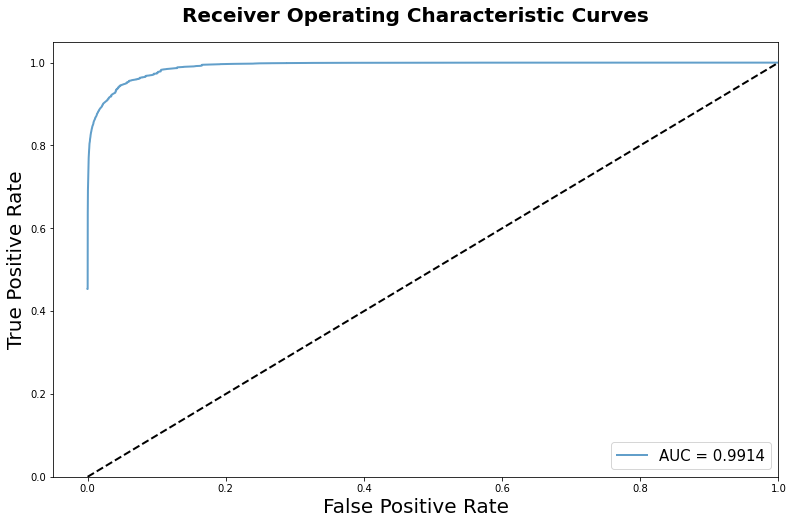

In [ ]:
plt.figure(figsize=(13, 8))
lw = 2

predictions = model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1],-1)

y_test_here = y_test.reshape(-1)
cidx = np.where(y_test_here != 17)[0]
y_test_here = y_test_here[cidx]
predictions_ = predictions[cidx,:-1] + np.ones(predictions[cidx,:-1].shape) * np.expand_dims(predictions[cidx,-1] / 17,axis=-1)

# find macro fpr tpr and auc
fpr, tpr, roc_auc = macro_ROC(y_test_here, predictions_)
plt.plot(fpr, tpr, lw=lw, alpha = 0.7, label=f'AUC = {roc_auc:0.4f}')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic Curves', pad = 20,fontsize=20,weight="bold")
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

### Precsion Recall Curves
***

In [ ]:
def macro_precision_recall(y_true, y_pred):
  """
    Gets true y and predictions and returns macro Precision and Recall
  """ 

  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()

  # y_true to 1-hot
  y_true = to_categorical(y_true, num_classes=17)

  # A macro-average score on all classes jointly
  precision_macro, recall_macro, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
  auc_pr_r = auc(recall_macro, precision_macro)

  return precision_macro, recall_macro, auc_pr_r
  

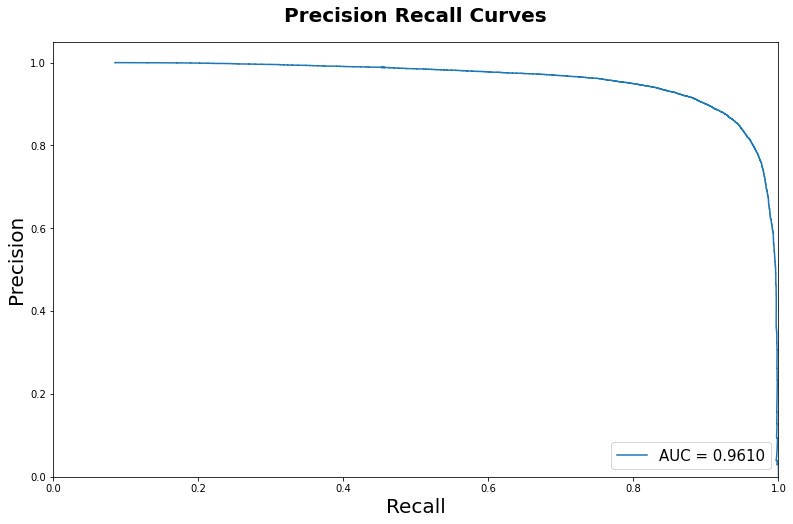

In [ ]:
plt.figure(figsize=(13, 8))
lw = 2

#find macro fpr tpr and auc
pr, re, auc_pr_r = macro_precision_recall(y_test_here, predictions_)
plt.step(pr, re, where='post',label=f'AUC = {auc_pr_r:0.4f}')

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curves', pad = 20, fontsize=20, weight="bold")
plt.legend(loc="lower right", prop={'size': 15})
plt.show()